<a href="https://colab.research.google.com/github/oscarserc/TESIS-_SARSA/blob/main/Test_a_p20_SARSA_APRENDIZAJE_solo_EMOCIONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1). Cargamos algunas librerías empleadas en la creación de agentes y fijamos los valores de los parámetros.**

In [1]:
# Importamos las LIBRERÍAS
import numpy as np
import pandas as pd
import random

# En primer lugar procedemos a especificar los parámetros que se emplearán a lo largo del
# PROGRAMA
# =======================================================================================
# PARÁMETROS
# ----------
alfa    = 0.1     # TASA DE APRENDIZAJE
gamma   = 0.1     # TASA DE DESCUENTO
epsilon = 0.01    # probabilidad de EXPLORACIÓN    #----> PRIMERO PUSE 0.2
num_estados  = 4  # EMOCIONES - Pongo 4: Alegría, Tristeza, Ira, Miedo 
num_acciones = 2  # Cooperar o NoCooperar

# Recompensas intrínsecas
r_alegria      = 2
r_ira          = 2
r_tristeza     = 2
r_miedo        = 2
beta           = 0.5

# TAMAÑOS POBLACIONALES (Inicialmente ponemos todos AGENTES EMOCIONALES)
probabilidad_clases = np.zeros(3)
# Para la experimentación con TRAIDORES poner un parámetro 'p' por ejemplo, y hacerlo recorrer el intervalo
#     p in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
#            probabilidad_clases[0] = 1 - p
#            probabilidad_clases[1] = p
probabilidad_clases[0] = 0.8    # Primer punto de corte > Si es menor que: 100 deja hueco por encima a  TRAIDOR  INGENUO  Tit-for-Tat
probabilidad_clases[1] = 0.2    #                         Por encima:                                      -     INGENUO  Tit-for-Tat
probabilidad_clases[2] = 0.0    #                         Por encima:                                      -        -     Tit-for-Tat

# TAMAÑO DE LA CUADRICULA (Grid) - Por ejemplo: (size=10)  =>  (10 filas x 10 columnas)
size = 10 # 20

LISTA_MUTANTES = []
LISTA_NODOS_VECINOS = []
MATRIZ_ADYACENCIA_Red_Social = np.zeros((size*size + 1, size*size + 1))


#**2). Definimos las clases principales que intervienen en el programa**

In [2]:
# CLASES PRINCIPALES
# ==================

# 1) Clase AGENTE  >>> Primera prueba: (Agente con exploración epsilon-greedy)
# ---------------
class AgenteEmocional(object):
  def __init__(self, alfa=0.1, gamma=0.1):
     self.alfa     = alfa
     self.gamma    = gamma
     self.estados  = num_estados
     self.acciones = num_acciones
     self.MUTANTE               = 0  
     self.TRAICIONADO           = 0  # A cero mientras no sea traicionado
     self.num_vecinos           = 0
     self.Numero_nodo           = 0
     self.lista_nodos_vecinos   = [] # Preparo para distribuir pagos a todos los jugadores que intervienen en la jugada
     self.lista_vecinos_grid    = [] # y para crear una MATRIZ de ADYACENCIA y dibujar un grafo de la Red-Grid
     
     # RECOMPENSAS y GANANCIAS
     # -----------------------
     self.recompensa            = 0
     self.recompensa_intrinseca = 0
     self.ganancias             = []
     self.ganancias_acumuladas  = []
     
     # ESTADOS EMOCIONALES (S y S')
     # ----------------------------
     self.emocion               = np.random.randint(num_estados) # Emocion inicial
     self.emocion_tras_jugada   = 0                              # Un valor cualquiera, se modificará de inmediato
     self.MATRIZ_ADYACENCIA_EMOCIONES = np.zeros((4,4))          # GUARDAMOS LAS TRANSICIONES
     self.SERIE_ALEGRIA         = []
     self.SERIE_ALEGRIA.append(0)
     self.SERIE_IRA             = []
     self.SERIE_IRA.append(0)
     self.SERIE_TRISTEZA        = []
     self.SERIE_TRISTEZA.append(0)
     self.SERIE_MIEDO           = []
     self.SERIE_MIEDO.append(0)
     if (self.emocion == 0):
       self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
     elif (self.emocion == 1):
       self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1
     elif (self.emocion == 2):
       self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
     elif (self.emocion == 3):
       self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1
     # Usaremos CODIFICACIÓN:    ALEGRIA = 0  /  IRA = 1  /  TRISTEZA = 2  /  MIEDO = 3
    
     # DECISIONES
     # ----------
     self.accion_propia         = 0  # Un valor cualquiera, se modificará de inmediato
     self.accion_vecindario     = 0  # Un valor cualquiera, se modificará de inmediato
     self.numero_cooperadores   = 0 
     self.DECISIONES            = []
     self.contador_inicio       = 0  # USO UN CONTADOR PARA TitForTat
     self.SERIE_COOPERACIONES   = []
     self.SERIE_COOPERACIONES.append(0)

     # PROCESO DE APRENDIZAJE
     # ----------------------
     self.matriz_Q = np.zeros((num_estados, num_acciones))
     self.ERRORES               = []

  def Fijar_vecinos(self,vecinos):
    self.num_vecinos = vecinos

  def Vecinos(self):
    return self.num_vecinos  

  def Fijar_num_cooperadores(self, numero):
    self.numero_cooperadores = numero

  def Fijar_intensidad_emocional(self, intensidad):
    self.intensidad_emocional = intensidad

  def Q(self):
    return self.matriz_Q


  # DECISIONES: epsilon-greedy
  def Tomar_decision(self, estado):
    # ---------------------------------
    # LA LLAMADA PARA LA TOMA DE DECISIONES SE REALIZA EN EL PROCEDIMIENTO
    # step()
    # -------------------------------------------------------------------------------
    TRAIDOR   = 1 # No coopera nunca
    INGENUO   = 2 # Coopera siempre a ciegas
    TitForTat = 3 # Coopera hasta que le traicionan y DEJA DE COOPERAR PARA SIEMPRE
    
    valor_aleatorio = np.random.uniform(0,1)

    # DECISIÓN e-greedy
    # -----------------
    if valor_aleatorio < epsilon:
        accion = np.random.randint(num_acciones)          # epsilon-probabilidad
        self.accion_propia = accion   # <---------------- Aquí surge la ACCIÓN inicio
    else:
        Qs = self.matriz_Q[estado]  
        accion = np.argmax(Qs)                            # max Q(s,a)
        self.accion_propia = accion   # <---------------- Aquí surte la ACCIÓN inicio
    # -------------------------------------------------------------------------------    
        
    # Si es MUTANTE toma decisiones de la siguiente manera:    
    if (self.MUTANTE == TRAIDOR):           # AGENTE TRAIDOR
        accion = 0    
    elif (self.MUTANTE == INGENUO):         # AGENTE INGENUO
        accion = 1
    elif (self.MUTANTE == TitForTat):       # AGENTE TitForTat
        #if (self.TRAICIONADO):
        #    accion = 0
        #else:
        #    accion = 1                     # CAMBIO A TOMA y DACA
        #accion = self.accion_vecindario    # pero falta comprobar COOP en la 1ª
        if (self.contador_inicio == 0):     # ACTUALIZAR EL CONTADOR
            accion = 1
        else:
            accion = self.accion_vecindario
    # ----------------------------------------------------- 
    self.contador_inicio = self.contador_inicio + 1
    
    return accion



  def Accion(self):
    return self.accion_propia

  def Accion_vecindario(self, accion_vecinos):
    self.accion_vecindario = accion_vecinos

  def Recompensa(self, recompensa):
    self.recompensa = recompensa


  def nuevo_estado(self, accion_vecindario):
    ALEGRIA      = 0
    IRA          = 1
    TRISTEZA     = 2  # cambio CULPABILIDAD por TRISTEZA
    MIEDO        = 3

    No_COOPERAR  = 0
    COOPERAR     = 1
    
      
    # Series temporales de estados emocionales
    # ----------------------------------------
    # Como primer paso incrementamos la serie, copiando el estado previo
    # Luego en los IF encadenados se INCREMENTA el que realmente ocurre  
    self.SERIE_ALEGRIA.append(self.SERIE_ALEGRIA[-1])
    self.SERIE_IRA.append(self.SERIE_IRA[-1])
    self.SERIE_TRISTEZA.append(self.SERIE_TRISTEZA[-1])
    self.SERIE_MIEDO.append(self.SERIE_MIEDO[-1])
    # ------------------------------------------------------------------


    # Parámetro de DESESCALADA
    # -------------------------
    Beta                 = 0.5
    evaluacion_situacion = np.random.uniform(0,1)
    # ----------------------------------------

    # ==========================================# 
    # TIPO DE JUEGO = 0 (Dilema del Prisionero) #
    # ==========================================#
    #
    # Partimos de Estado inicial: ALEGRÍA  ('0')
    # ---------------------------
    if ((self.emocion == ALEGRIA) and (self.accion_propia == COOPERAR)):              # Está ALEGRE y COOPERA
        if (self.accion_vecindario == COOPERAR):           #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_alegria
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1
        else:                                       #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA  
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][IRA] += 1
    elif ((self.emocion == ALEGRIA) and (self.accion_propia == No_COOPERAR)):      # Está ALEGRE y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][TRISTEZA] += 1
        else:
            self.emocion_tras_jugada   = ALEGRIA  
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1

    # Partimos de Estado inicial: IRA  ('1')
    # ---------------------------
    if (self.emocion == IRA) and (self.accion_propia == COOPERAR):                 # Está IRACUNDO y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = IRA
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1   # parece error IRA y VECINOS COOPERAN => TRISTEZA    mirar  ***************************************
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA   
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1

    elif (self.emocion == IRA) and (self.accion_propia == No_COOPERAR):          # Está IRACUNDO y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            # TIENE SUFICIENTE GRAVEDAD COMO PARA NO CONSIDERAR
            # NINGÚN FACTOR PARA DESESCALAR
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA   
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = r_ira  
                self.TRAICIONADO = 0    # Antes a 1, pongo a 0
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1
            # AHORA SI SE SIENTE SOBREPASADO POR LA SITUACIÓN
            # Y ES MEJOR DESESCALAR
            # Beta ----> Tendencia a eludir la confrontación
            #            No es para tanto, y merece la pena frenar
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][MIEDO] += 1
            

    # Partimos de Estado inicial: TRISTEZA  ('2')
    # ---------------------------
    if (self.emocion == TRISTEZA) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_tristeza
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1
    elif (self.emocion == TRISTEZA) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = IRA  
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1

    # Partimos de Estado inicial: MIEDO  ('3')
    # ---------------------------
    if (self.emocion == MIEDO) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_miedo
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
    elif (self.emocion == MIEDO) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos COOPERAN
            # TIENE SUFICIENTE GRAVEDAD COMO PARA NO CONSIDERAR
            # NINGÚN FACTOR PARA DESESCALAR
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA  
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ 
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
            # AHORA SI SE SIENTE SOBREPASADO POR LA SITUACIÓN
            # Y ES MEJOR DESESCALAR
            # Beta ----> Tendencia a eludir la confrontación
            #            No es para tanto, y merece la pena frenar
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][MIEDO] += 1

    # AQUÍ TENDRÍA QUE PONER EL GRAFO
    # SEGÚN EL TIPO DE JUEGO
    # ==========================================# 
    # TIPO DE JUEGO = 1 (Juego del Gallina)     #
    # ==========================================#
    
    return self.emocion_tras_jugada

   

   
  def paso_aprendizaje(self):
    # Convertimos a la denominación habitual estado/accion/recompensa
    # para expresar la formula
    #----------------------------------------------------------------
    #
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)
    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca  #  <== AHORA APRENDIZAJE SÓLO EMOCIONAL   **************************
    r = self.recompensa_intrinseca

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)
    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    # y hacemos un append ya para la siguiente pasada, dadon por hecho no cooperar
    # si sale cooperar en el if se incrementa   
    #
    # Podría comprobar si: len(self.SERIE_COOPERACIONES != CICLOS)
    # en cuyo caso preparamos para la siguiente iteración con la instrucción: 
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])


    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    # -----------------
    # Algoritmo SARSA          # < ================================================ ALGORITMO DE APRENDIZAJE
    # -----------------
    # APRENDIZAJE:
    target = float(r) + gamma * self.matriz_Q[estado_nuevo][accion_nueva]   # <---- CAMBIO EN ESTA LINEA (Quito max(), y pongo index por a_nueva)
    error  = target - self.matriz_Q[estado][accion]
    self.ERRORES.append(error)
    self.matriz_Q[estado][accion] = self.matriz_Q[estado][accion] + (alfa*error)

    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva



 
# 2) Clase AMBIENTE
# -----------------
# Esta clase debe enviar: (s,r)
# Es decir: el estado siguiente (s) - o la información para determinarlo -
# (en este caso las estrategias de los otros jugadores)
# y además la RECOMPENSA DEL DILEMA (r)
class Environment(object):
  def __init__(self, size_):
    # CREAMOS UNA MATRIZ DE ADYACENCIA (Registraremos en ella las cooperaciones)
    self.MATRIZ_Adj = np.zeros((size_*size_ + 1, size_*size_ + 1))

    # Para las MATRICES DE PAGOS:
    # ---------------------------
    self.matriz_pagos_J1 = np.zeros((2,2))
    self.matriz_pagos_J2 = np.zeros((2,2))

    # ================================
    # MATRIZ DEL Dilema del Prisionero   Por ahora sólo pongo en exhaustivo este JUEGO
    # ================================
    # MATRIZ DE PAGOS del Jugador 1 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J1[0][0] = 0   
    self.matriz_pagos_J1[0][1] = 5
    self.matriz_pagos_J1[1][0] = 0   
    self.matriz_pagos_J1[1][1] = 3

    # MATRIZ DE PAGOS del Jugador 2 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J2[0][0] = 0   
    self.matriz_pagos_J2[0][1] = 0
    self.matriz_pagos_J2[1][0] = 5   
    self.matriz_pagos_J2[1][1] = 3
    # -------------------------------------------------------------------------

    # PARA ACCESO DESDE AFUERA
    self.p = []
    # ------------------------

    # VALORES INICIALIZADOS EN LA ZONA DE PARÁMETROS al principio
    # -----------------------------------------------------------
    # probabilidad_clases[0] recoge la PROPORCIÓN de AGENTES_EMOCIONALES
    # probabilidad_clases[1] recoge la PROPORCIÓN de AGENTES TRAIDORES
    #                        sumando las dos anteriores tenemos el punto
    #                        de corte 'p1' por debajo del cual, y  por encima
    #                        de 'p0' que da el intervalo, de tal manera que
    #                        cayendo dentro el número aleatorio será 
    #                        considerado un AGENTE TRAIDOR
    p0 = probabilidad_clases[0]
    p1 = probabilidad_clases[1] + p0
    p2 = probabilidad_clases[2] + p1
    p3 = 1.

    # Para acceso desde fuera
    self.p.append(p0)
    self.p.append(p1)
    self.p.append(p2)
    self.p.append(p3)
    # -----------------------

    # ------------------------------------------------------
    # AQUÍ CONTROLAMOS SI EL AGENTE EMOCIONAL SUFRE MUTACIÓN
    # ------------------------------------------------------
    self.size = size_
    self.Grid = np.full((size + 2, size + 2), AgenteEmocional)
    #
    # ***   AÑADIDO. Si no, crea matriz de REFERENCIAS a un SÓLO OBJETO    ***
    #
    for i in range(1,size+1,1):                # Antes puse: range(size)
        for j in range(1,size+1,1):
            self.Grid[i][j] = AgenteEmocional()
            #print(id(self.Grid[i][j])) # Dirección de Memoria del OBJETO AgenteEmocional
    #        
    # ************************************************************************* 
    # SÓLO PERCIBIDO AL INTENTAR ACCEDER A POSTERIORI A PROPIEDADES DE ELLOS
    #                   (14 de Abril de 2022)
    #       Siempre salían MUTANTES del mismo tipo todos los individuos
    # *************************************************************************       

    global LISTA_MUTANTES

    for i in range(1, size+1, 1):
        for j in range(1, size+1, 1):
            valor_aleatorio = np.random.uniform(0,1) 
            #print(valor_aleatorio)   
            if   (p0 < valor_aleatorio <= p1):
                self.Grid[i][j].MUTANTE = 1    # <---- Lo creamos TRAIDOR  
                LISTA_MUTANTES.append(1) 
                
                # -----------------------------------------------------------------------------------------------------
                # LOS PRINTS SALEN BIEN, pero luego accediendo individualmente al GRID y a los jugadores
                # salen todos '0'. No sé si hay problemas a la hora de dar valor en el init con
                # selecciones if-else
                # El resto parece ir bien, aunque no sé si es por hacerse todo durante la ejecución
                # y si intentando acceder a algún tipo de parámetro ocurriría igual
                # -----------------------------------------------------------------------------------------------------
                #### print('CREADO MUTANTE tipo 1 (Traidor) - coordenadas: ','(',i,',',j,') ', self.Grid[i][j].MUTANTE)
                # print('HOLA SOY UN MUTANTE 1')   Sí se mete aquí, pero luego no modifica la propiedad MUTANTE 
            elif (p1 < valor_aleatorio <= p2):
                self.Grid[i][j].MUTANTE = 2    # <---- Lo creamos INGENUO
                LISTA_MUTANTES.append(2)
                #### print('CREADO MUTANTE tipo 2 (Ingenuo)')
            elif (p2 < valor_aleatorio <= p3):
                self.Grid[i][j].MUTANTE = 3    # <---- Lo creamos TifForTat
                LISTA_MUTANTES.append(3)
                #### print('CREADO MUTANTE tipo 3 (Tit For Tat')


    for i in range(1, size+1, 1):
        for j in range(1, size+1, 1):  
          LISTA_MUTANTES.append(self.Grid[i][j].MUTANTE)                
    # -------------------------------------------------------                     
    # -------------------------------------------------------             
    

    # PROBAMOS A INCLUIRLO EN EL __init__. Antes: def inicializar_tablero(self):
    # ASIGNAMOS VECINOS al crear OBJETOS (Para graduar la intensidad emocional)
    # ----------------------------------
    # · AL INTERIOR DEL TABLERO:            <-------------- 8 VECINOS
    for i in range(size+2):
        for j in range(size+2):
            self.Grid[i][j] = AgenteEmocional() 
            if ((i>1 and i<size) and (j>1 and j<size)):
                self.Grid[i][j].Fijar_vecinos(8)  
            else:
                self.Grid[i][j].Fijar_vecinos(0)

    # · A LAS ESQUINAS                      <-------------- 3 VECINOS
    self.Grid[1][1].Fijar_vecinos(3)
    self.Grid[size][size].Fijar_vecinos(3)
    self.Grid[size][1].Fijar_vecinos(3)
    self.Grid[1][size].Fijar_vecinos(3)

    # · AL BORDE                            <-------------- 5 VECINOS
    for columna in range(2,size,+1): self.Grid[1][columna].Fijar_vecinos(5)
    for columna in range(2,size,+1): self.Grid[size][columna].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][1].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][size].Fijar_vecinos(5)


    # Añadido: 17 de Abril de 2022 (Pruebo a añadir pagos a todos los jugadores, y preparo para MATRIZ de ADYACENCIA)
    # -------------------
    # Numeramos los nodos - También podría hacerse la asignación de num_vecinos como longitud de los siguientes vectores
    # -------------------
    filas    = size_
    columnas = size_
    for fila in range(1,filas+1,1):
      for columna in range(1,columnas+1,1):
        self.Grid[fila][columna].Numero_nodo = (fila-1)*(columnas) + columna 


    global LISTA_NODOS_VECINOS

    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por numero nodo)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for _ in range(1,size*size,1):
          nodo = self.Grid[i][j].Numero_nodo
          if   (i==1 and j==1):                           # ESQUINA (1,1)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo+1, nodo+size, nodo+size+1])
          elif (i==1) and (j in list(range(2,size))):     # Fila de abajo
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+1, nodo+size-1, nodo+size, nodo+size+1])
          elif (i==1 and j==size):                        # ESQUINA (1,size)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+size-1, nodo+size])
          elif (i in list(range(2,size,1)) and j==1):     # Columna izquierda
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1, nodo+size, nodo+size+1])
          elif (i in list(range(2,size,1)) and j==size):  # Columna derecha
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1, nodo+size-1, nodo+size])
          elif (i==size and j==1):                        # ESQUINA (size,1)   
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1])
          elif (i==size and j in list(range(2,size))):    # Fila superior
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1, nodo-1, nodo+1])
          elif (i==size and j==size):                     # ESQUINA (size,size)  
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1])
          else:                                           # Grid central
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1,
                                                        nodo-1, nodo+1, 
                                                        nodo+size-1, nodo+size, nodo+size+1])
          LISTA_NODOS_VECINOS.append(self.Grid[i][j].lista_nodos_vecinos)  
          break
    # -------------------------------------------------------
    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por fila-columna en el grid)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
          lista =  self.Grid[i][j].lista_nodos_vecinos

          for numero_nodo in lista:
            if ((numero_nodo % size) == 0):
              fila = (numero_nodo // size) # quito: -1 , para un grid 1..size
              columna = size
            else:
              fila = (numero_nodo // size) + 1
              columna = numero_nodo % size
            self.Grid[i][j].lista_vecinos_grid.append((fila, columna))
    # --------------------------------------------------------------------------------------        

  '''
  '''

  def Devolver_Grid(self):
    return self.Grid

  def Devolver_Matriz_Adj(self):
    return self.MATRIZ_Adj

  def step(self):
    num_cooperadores = 0
    reward           = 0
    Vecinos_Cooperan = 0
    filas    = size
    columnas = size
    recompensa = 0

    # CREAMOS UNA MATRIZ CUADRADA de (size x size)
    # CON UN BORDE ALREDEDOR
    acciones   = np.zeros((size+2, size+2),dtype=int)
    emociones  = np.zeros((size+2, size+2),dtype=int)
    intensidad = np.zeros((size+2, size+2))

    # Aquí cada AGENTE toma su DECISIÓN:
    for i in range(1,filas+1,+1):
        for j in range(1,columnas+1,+1):
            # ESTO CONSTITUIRÁ EL 'FRAME' con las acciones en un paso 
            estado            = self.Grid[i][j].emocion
            acciones[i][j]    = self.Grid[i][j].Accion()                                               #   (A)
            emociones[i][j]   = self.Grid[i][j].emocion                                                #   (E)

    # MATRIZ de ADYACENCIA - En ella acumulamos COOPERACIONES para dibujar después
    # --------------------
    #for i in range(1,size+1,1):
    #  for j in range(1,size+1,1):
    #    for nodo_vecino in self.Grid[i][j].lista_nodos_vecinos:
    #      if (self.Grid[i][j].Accion()):  
    #        self.MATRIZ_Adj[nodo_vecino] += 1    # ********************************************* TENER EN CUENTA EL NODO ORIGEN


    # MATRIZ de ADYACENCIA - En ella acumulamos COOPERACIONES para dibujar después
    # --------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for nodo_vecino in self.Grid[i][j].lista_nodos_vecinos:
          if (self.Grid[i][j].Accion()):  
            self.MATRIZ_Adj[self.Grid[i][j].Numero_nodo][nodo_vecino] += 1
    # Volcamos el contenido en la variable global
    global MATRIZ_ADYACENCIA_Red_Social
    MATRIZ_ADYACENCIA_Red_Social = self.MATRIZ_Adj
    # --------------------------------------------


    # Ahora recopilamos todos los resultados del ENTORNO para enviar al AGENTE
    for i in range(1,size+1,+1):
        for j in range(1,size+1,+1):
            cooperadores = self.Grid[i-1][j-1].Accion() + self.Grid[i-1][j].Accion() + self.Grid[i-1][j+1].Accion() + \
                           self.Grid[i][j-1].Accion()   +                              self.Grid[i][j+1].Accion()   + \
                           self.Grid[i+1][j-1].Accion() + self.Grid[i+1][j].Accion() + self.Grid[i+1][j+1].Accion() 

            grado_unanimidad_cooperacion = (cooperadores / self.Grid[i][j].Vecinos())

            # --------------------------------------------------------
            #  AQUÍ PODRÍA AÑADIR LO QUE ME FALTA: 
            #       -> Poner pagos para el resto de jugadores 
            #  y MANEJAR LA INFORMACIÓN PARA CREAR UN GRAFO DE LA RED
            #       -> Actualizar una MATRIZ_ADYACENCIA con las
            #          COOPERACIONES entre nodos
            # --------------------------------------------------------

            if (grado_unanimidad_cooperacion > 0.5):
                Vecinos_Cooperan = 1
            self.Grid[i][j].Accion_vecindario(Vecinos_Cooperan)
            self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_cooperacion)
            # LA OTRA MATRIZ QUE TENEMOS QUE EMPLEAMOS 
            intensidad[i][j] = grado_unanimidad_cooperacion                                           # (I)
            a_J1 = acciones[i][j]   
            a_J2 = Vecinos_Cooperan
            self.Grid[i][j].Fijar_num_cooperadores(cooperadores)  
            self.Grid[i][j].Recompensa(self.matriz_pagos_J1[a_J1][a_J2])  
            self.Grid[i][j].paso_aprendizaje()

    return acciones, emociones, intensidad  




#**3). Creamos una instancia del entorno y realizamos algunos ciclos para comprobar cómo se comporta el ERROR**

In [3]:
env = Environment(size)

# SE PUEDE PROBAR CON CICLOS CORTOS
# ya que con 2000 ya va muy entrenado
# y en el procedimiento de dibujo abajo
# sale muy avanzado

# -------------------------
# VALOR de entrada: 2000
# Pruebo otros menores: 200
# -------------------------


CICLOS = 2000

# CONJUNTO de 2000 CICLOS
for _ in range(CICLOS):
  env.step()

# SI IMPRIMIMOS DIRECCIONES DE MEMORIA: Son size*size objetos distintos pero
# diferentes a los que se manejan dentro de la celda

#grid = env.Devolver_Grid()
#for i in range(1,size+1,1):        
#  for j in range(1,size+1,1):
#    print(id(grid[i][j]))


 

In [ ]:
grid = env.Devolver_Grid()

for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    print(grid[i][j].MUTANTE)



#**Representamos gráficamente la matriz Q de decisiones de uno de los agentes**

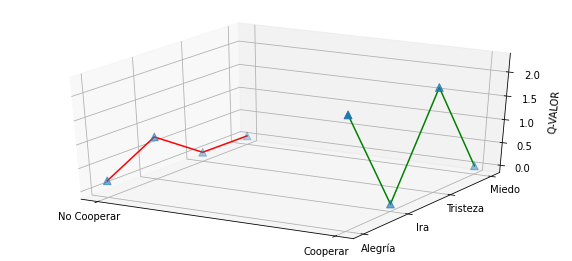

In [4]:
# Matriz Q con los valores de cada ACCIÓN en cada ESTADO
# en uno de los agentes (Por ejemplo el (3,4))

# IMPORTAMOS LAS LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# OBTENEMOS UNA COPIA DEL GRID
Grid2 = env.Devolver_Grid()

# EXTRACCIÓN DE LA MATRIZ Q
# -------------------------
matriz_Q = Grid2[4][4].Q() 
matriz_Q

# REPRESENTACIÓN GRÁFICA DE LA MATRIZ Q
# -------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211, projection ='3d')

rango_acciones  = np.arange(0,2)
rango_emociones = np.arange(0,4)

X, Y = np.meshgrid(rango_acciones, rango_emociones)
Z    = matriz_Q
ax.scatter3D(X, Y, Z, marker='^', s=60)

ax.plot3D([0,0,0,0], [0,1,2,3], Z[:,0], 'red')
ax.plot3D([1,1,1,1], [0,1,2,3], Z[:,1], 'green')
#ax.set_xlabel('ESTRATEGIA')
#ax.set_ylabel('EMOCIONES')
ax.set_zlabel('Q-VALOR')
locs, labels = xticks()
locs, labels = yticks()
xticks([0, 1], ['No Cooperar', 'Cooperar'])
yticks([0, 1, 2, 3], ['Alegría', 'Ira', 'Tristeza','Miedo'])

plt.show()




#**5). Creamos una animación con la evolución emocional y de la cooperación**

<function matplotlib.pyplot.close>

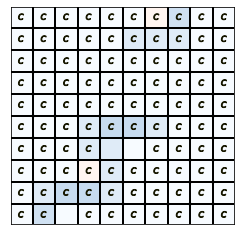

In [5]:
# IMPORTAMOS LAS LIBRERÍAS
# ------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from matplotlib import animation, rc
rc('animation',html='html5')
import numpy as np
import pandas as pd
%matplotlib inline


# ASOCIAMOS COLORES A EMOCIONES para posteriormente dibujarlas
# -----------------------------------------------------------------------------
cmaps = []
cmaps.append(mpl.cm.Blues_r)      # Tristeza (azul)        => 0  ok
cmaps.append(mpl.cm.Greens_r)     # Alegría      (verde)   => 1  ok
cmaps.append(mpl.cm.Reds_r)       # Ira          (rojo)    => 2  ok
# PARECE QUE SE VE MEJOR QUE EL GRIS LO PONGO DE MIEDO
                                  # Miedo        (gris)    => 3  ok
cmaps.append(mpl.cm.Purples_r)    # Envidia      (púrpura) => 5
cmaps.append(mpl.cm.Greys_r)      # Miedo        (gris)    => 3
cmaps.append(mpl.cm.Oranges_r)    #              (naranja) => 4
cmaps.append(mpl.cm.Purples_r)    # Envidia      (púrpura) => 5
# -----------------------------------------------------------------------------

# CONSTRUIMOS UNA MALLA DEL TAMAÑO DE LAS MATRICES para luego utilizarla en el dibujo
x = np.arange(0,size)
y = np.arange(0,size)
malla_dibujo = np.meshgrid(x,y)

# Fijamos el tamaño de la ventana en relación al tamaño del GRID
ratio = 0.4
fig, axes = plt.subplots(figsize=(ratio*size,ratio*size))
axes.set_facecolor("black")
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)


def update(i):
  acciones, emociones, intensidad = env.step()
  acciones_   = acciones[1:size+1,1:size+1]
  emociones_  = emociones[1:size+1,1:size+1]
  intensidad_ = intensidad[1:size+1,1:size+1]


  # ------------------------- 
  # TRANSFORMACIÓN: emociones  > CORREGIMOS EL GIRO ESPECULAR del meshgrid
  # -------------------------
  emociones_reverse_filas = emociones_[::-1]
  emociones___t = emociones_reverse_filas.flatten()
  # --------------------------------
  # TRANSFORMACIÓN: intensidad
  # -------------------------
  intensidad_reverse_filas = intensidad_[::-1]
  intensidad___t = intensidad_reverse_filas.flatten()
  # --------------------------------
  # TRANSFORMACIÓN: acciones
  # --------------------------------
  acciones_reverse_filas = acciones_[::-1]
  acciones___t = acciones_reverse_filas.flatten()
  # --------------------------------


  # v1 (antes de la corrección de la imagen especular)
  # --
  # Se degrada el color según baja el nivel de intensidad
  #colores     = [cmaps[color](intensidad) for color,intensidad in zip(emociones_.flatten(),intensidad_.flatten())]

  colores     = [cmaps[color](intensidad) for color,intensidad in zip(emociones___t,intensidad___t)]

  # v2 (30 Marzo 2022)
  # --
  # CAMBIO SIGUIENTE LINEA para dar vuelta a imagen especular que sale
  # ¡¡¡ !!!
  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones.flatten()]
  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones___t]   # SOLO EMOCIONAL sale muy claro cambio a negro


  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones.flatten()]
  #color_negro   =  [(0.090,0.090,0,1) if Coopera else (0,0,0,0) for Coopera in acciones_.flatten()]
  color_negro =  [(0.090,0.090,0,1) if Coopera else (0,0,0,0) for Coopera in acciones___t]       # PONGO COLOR NEGRO

  dibujo = axes.scatter(*malla_dibujo, marker='s', s=380)
  dibujo.set_facecolor(colores)
  # Sobreimpresionamos una 'C' cuando el agente COOPERA
  dibujo2 = axes.scatter(*malla_dibujo, marker='$C$')
  
  #dibujo2.set_facecolor(color_amarillo)
  dibujo2.set_facecolor(color_negro)                                                            # CAMBIO TAMBIÉN AQUÍ
  
  return axes

# Creamos una animación con 40 ejecuciones (frames=40), y la separación entre los
# frames es de 1 segundo (interval=1000)
animacion = animation.FuncAnimation(fig, update, frames=40, interval=100)
plt.close

# -----------------------------------------------------------------------------------------
# inicialmente: interval = 1000
#               con 40 frames
# para valores más altos va lento. Pruebo a subir a 400 frames, y un valor mucho
# más pequeño para el intervalo (primero 100) que podría ser: 10.
#
# · PRUEBA 1 ----> frames (400) e interval (100) // éste último influye en la visualización
#                  tiempo de ejecución de este procedimiento: 14 minutos
#
# · PRUEBA 2 ----> frames (100) e interval (100)   *** pero con GRID (20*20)
#                  tiempo de ejecución                      :  5 minutos
# -----------------------------------------------------------------------------------------


In [6]:
animacion

# **PREPARAMOS UN GRAFO CON LAS TRANSICIONES ENTRE ESTADOS EMOCIONALES** (librería Graphviz)

In [7]:

# TRANSFORMAMOS LOS CONTEOS DE TRANSICIONES ENTRE EMOCIONES
# ---------------------------------------------------------
# Lo colocamos en un rango no muy alto (dividiendo por el total
# de transiciones para luego usar estos valores como grosor
# de las aristas)

Matriz_adj = Grid2[2][3].MATRIZ_ADYACENCIA_EMOCIONES
Matriz_adj = Matriz_adj*(18/CICLOS)
Matriz_adj


array([[11.943,  0.027,  0.243,  0.   ],
       [ 0.   ,  1.377,  0.027,  1.386],
       [ 0.27 ,  0.045,  0.288,  0.   ],
       [ 0.   ,  1.341,  0.045,  1.386]])

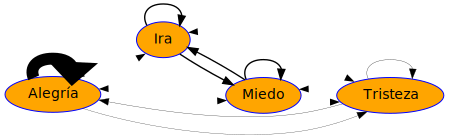

In [8]:
# IMPORTAMOS LAS LIBRERÍAS
# ------------------------
import networkx as nx
import graphviz as gv

# Create Digraph object
dot = gv.Digraph('wide')

# Add nodes
#dot.attr('node', shape='doublecircle') # O también: shape='circle'
dot.node('0', 'Alegría', color='blue', 
         fillcolor="orange", 
         style='filled', 
         fontname="Verdana")          # 0 es Alegría
dot.node('1', 'Ira', color='blue', fillcolor="orange", style='filled', fontname="Verdana")              # 1 es Ira
dot.node('2', 'Tristeza', color='blue', fillcolor="orange", style='filled', fontname="Verdana")         # 2 es Tristeza
dot.node('3', 'Miedo', color='blue', fillcolor="orange", style='filled', fontname="Verdana")            # 3 es Miedo

for emocion_inicial in range(4):
  for emocion_final in range(4):
    dot.attr('edge', penwidth=str(Matriz_adj[emocion_inicial][emocion_final]))
    dot.edge(str(emocion_inicial), str(emocion_final))

# ORIENTACIÓN DE IZQUIERDA A DERECHA
dot.graph_attr['rankdir'] = 'LR'  

# Visualize the graph
dot

# **PODRÍA REPRESENTARSE UN GRAFICO cumsum CON 4 LINEAS SEPARADAS**, una por emoción, y que tiene en cuenta la evolución temporal: cuando se produce la acumulación de transiciones

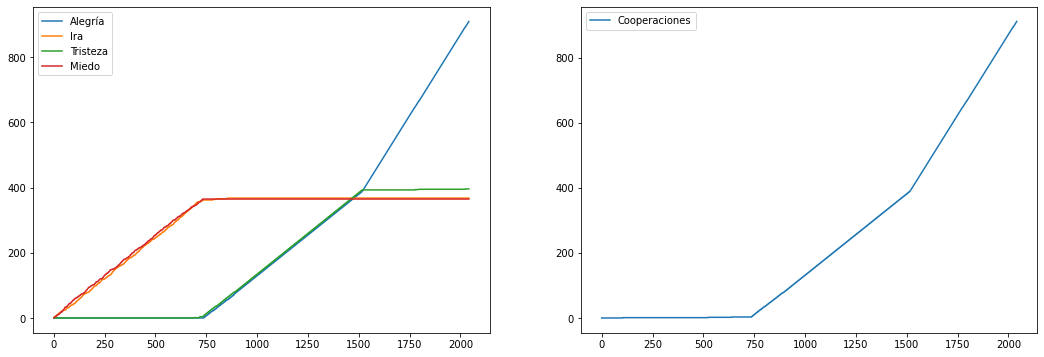

In [9]:

import matplotlib.pyplot as plt
%matplotlib inline

# OBTENEMOS UNA COPIA DEL GRID
Grid2 = env.Devolver_Grid()

# EXTRACCIÓN DE LAS SERIES EMOCIONALES
# ------------------------------------
serie1  = Grid2[4][4].SERIE_ALEGRIA 
serie2  = Grid2[4][4].SERIE_IRA
serie3  = Grid2[4][4].SERIE_TRISTEZA
serie4  = Grid2[4][4].SERIE_MIEDO
serie_c = Grid2[4][4].SERIE_COOPERACIONES[:-1]

fig = plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(serie1, label='Alegría')
plt.plot(serie2, label='Ira')
plt.plot(serie3, label='Tristeza')
plt.plot(serie4, label='Miedo')
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(serie_c, label='Cooperaciones')
plt.legend(loc='upper left')


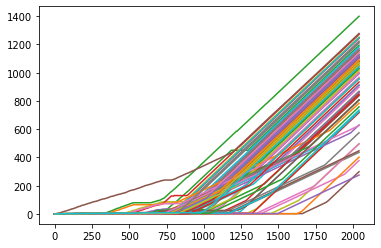

In [10]:

# GRÁFICA DE LA COOPERACIÓN ACUMULADA DE TODOS LOS AGENTES
# ========================================================

for i in range(size):
  for j in range(size):
    plt.plot(Grid2[i][j].SERIE_COOPERACIONES[:-1])

    

#**· LIBRERÍA Networkx**

In [ ]:

# OBTENEMOS UNA COPIA DEL GRID
# ----------------------------
Grid = env.Devolver_Grid()

# PARÁMETROS (tamaño y matriz de adyacencia)
# ----------
Matriz_adj = env.MATRIZ_Adj
Matriz_adj = Matriz_adj*(2/CICLOS)


# **Prueba 1**

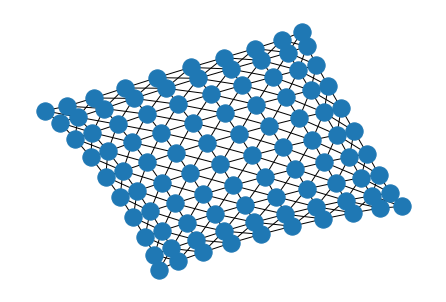

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# OBTENEMOS UNA COPIA DEL GRID
# ----------------------------
Grid = env.Devolver_Grid()

# Instanciamos para la representación de un grafo
# -----------------------------------------------
Grafo = nx.Graph()


for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    Grafo.add_node(Grid[i][j].Numero_nodo)

for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    Grafo.add_edges_from([(Grid[i][j].Numero_nodo, nodo_destino) 
                           for nodo_destino in Grid[i][j].lista_nodos_vecinos])

nx.draw(Grafo)


# **ENSAMBLADO FINAL (Representación de la Red Social por tipo de Agente)**

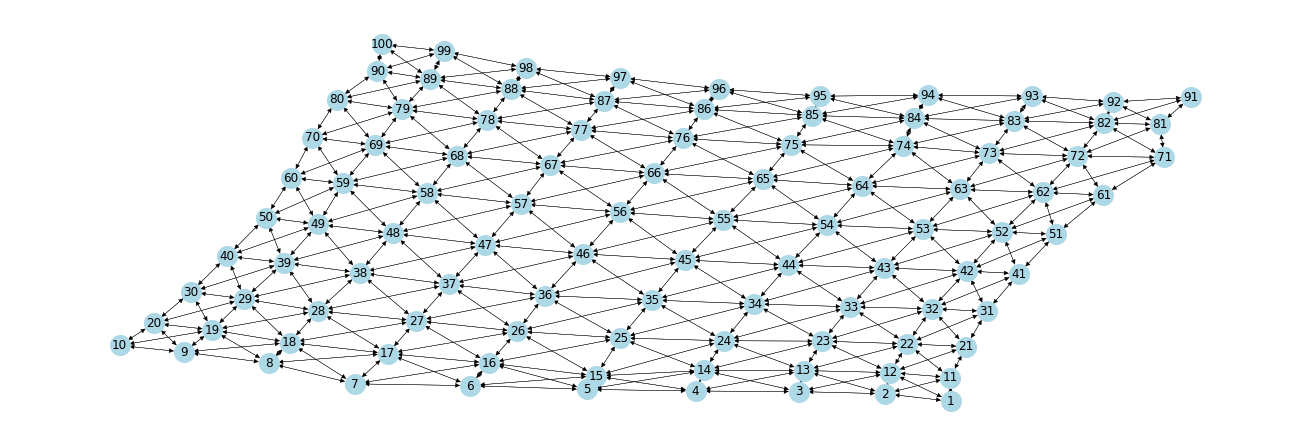

In [12]:

import matplotlib.pyplot as plt
import networkx as nx

# PREPARAMOS EL TAMAÑO DEL DIBUJO DE LA RED
# -----------------------------------------
plt.figure(figsize=(18,6))
#ax = fig.add_subplot(111)

# Instanciamos el GRAFO
# ---------------------
Grafo = nx.DiGraph()


# ======================
# PREPARAMOS EL GRÁFICO
# ======================

# LISTADO DE NODOS
# ----------------
contador_nodos = 1
for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    #self.Grafo.add_node(Grid[i][j].Numero_nodo)
      Grafo.add_node(contador_nodos)
      contador_nodos += 1


# LISTADO DE COLORES para los NODOS basado en el tipo de mutante
# --------------------------------------------------------------
#global 
LISTA_MUTANTES

color_legend = {'Agente Emocional': 'orange', 'Agente Traidor': 'red',
                'Agente Ingenuo': 'lightgreen'  , 'Agente TitForTat': 'lightgray'}
d = {0: 'orange', 1: 'red', 2: 'lightgreen', 3: 'lightgray'}
color_map = [d.get(x) for x in LISTA_MUTANTES]
# --------------------------------------------------------------


# PREPARAMOS LAS ARISTAS CON PESO PROPORCIONAL AL NÚMERO DE COOPERACIONES
# (entre los nodos que unen)
# -----------------------------------------------------------------------
for i in range(size):        
  for j in range(size):
    lista = [(i*size + j + 1, nodo_destino) 
                          for nodo_destino in LISTA_NODOS_VECINOS[i*size + j]]
    lista_ponderada = [(nodo_i, nodo_j, MATRIZ_ADYACENCIA_Red_Social[nodo_i][nodo_j]) 
                        for nodo_i, nodo_j in lista]  
    Grafo.add_weighted_edges_from(lista_ponderada)                   

# ===================================================================================                   

#nx.draw_networkx(Grafo, ax = ax, node_color=color_map)
#nx.draw_networkx(Grafo, node_color=color_map[:size*size])

nx.draw(Grafo, pos = nx.spring_layout(Grafo, k=0.8), with_labels = True, width=0.4, 
        node_color='lightblue', node_size=400)


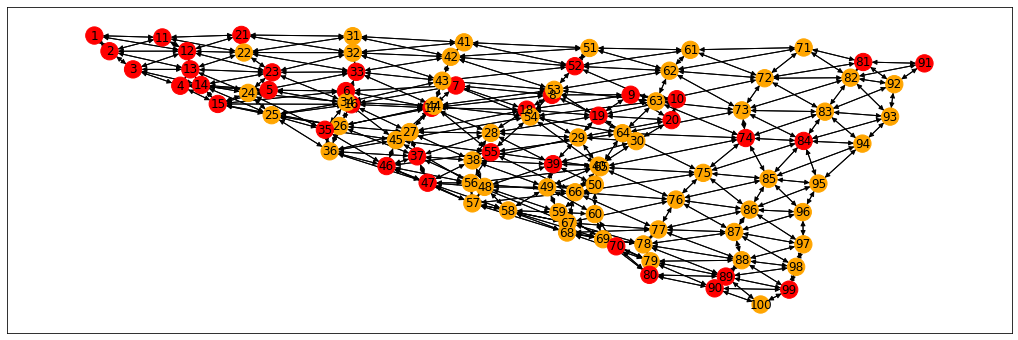

In [13]:

plt.figure(figsize=(18,6))

# NO SÉ PORQUE SALE UN ARRAY MUCHO MAYOR QUE LOS MUTANTES QUE AÑADO
# (Corto hasta el máximo para que coincida)
# -----------------------------------------------------------------
nx.draw_networkx(Grafo, node_color=color_map[:size*size])


# **ATENCIÓN: Se genera con el GRID subyacente de 12x12 (PADDING)**

In [ ]:
len(color_map), len(LISTA_MUTANTES)

(120, 120)

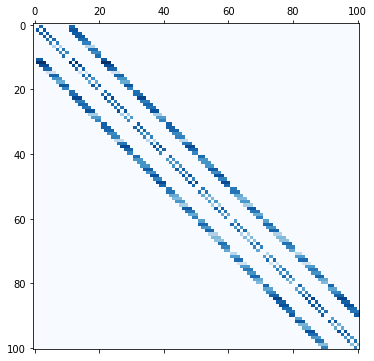

In [14]:
# DIBUJAMOS LA MATRIZ DE ADYACENCIA
# ---------------------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.matshow(MATRIZ_ADYACENCIA_Red_Social, cmap=plt.cm.Blues)

# **AHORA PASAMOS A LA PARTE DE EXPERIMENTACIÓN (variamos $\beta$ y p)**

In [15]:

import numpy as np

# Parámetros a variar:
# --------------------
#  · Beta: (parámetro de desescalada)
#  · Mutante - manejamos los parámetros:
#        probabilidad_clases[0] = (1-p)   
#        probabilidad_clases[1] = p

# Matriz para guardar los resultados experimentales
Resultados_Experimentos = np.zeros((10,10))

# CREAMOS UN PROCEDIMIENTO PARA EXPERIMENTAR
# ==========================================

def experimento(p, b):
  env = Environment(size)
  beta = b
  probabilidad_clases[0] = (1-p)   
  probabilidad_clases[1] = p

  CICLOS = 2000

  # CONJUNTO de CICLOS
  for _ in range(CICLOS):
    env.step()

  return env

cont1 = 0
cont2 = 0

# Parámetro 'p' por filas y parámetro 'b' por columnas
# ----------------------------------------------------

# Para reducir el impacto de la aleatoriedad repetimos para cada combinación
# de parámetros la prueba un número de veces dado por: REPETICIONES
# Luego guardamos la media de COOPERACIONES de las pruebas
REPETICIONES = 2 # 10
COOPERACIONES_ACUMULADAS = 0

for p in np.arange(0,1,0.1):
  print('Valor contador 1: ', cont1) 
  for b in np.arange(0,1,0.1):
    for prueba in range(REPETICIONES):
      e = experimento(p, b)
      COOPERACIONES_ACUMULADAS += np.sum(e.Devolver_Matriz_Adj())
    print('Valor contador 2 :', cont2)  
    Resultados_Experimentos[cont1][cont2] = COOPERACIONES_ACUMULADAS / REPETICIONES
    cont2 += 1
    COOPERACIONES_ACUMULADAS = 0
  #print('Valor contador 1: ', cont1)  
  print('---------------------------')
  cont2 = 0
  cont1 += 1






Valor contador 1:  0
Valor contador 2 : 0
Valor contador 2 : 1
Valor contador 2 : 2
Valor contador 2 : 3
Valor contador 2 : 4
Valor contador 2 : 5
Valor contador 2 : 6
Valor contador 2 : 7
Valor contador 2 : 8
Valor contador 2 : 9
---------------------------
Valor contador 1:  1
Valor contador 2 : 0
Valor contador 2 : 1
Valor contador 2 : 2
Valor contador 2 : 3
Valor contador 2 : 4
Valor contador 2 : 5
Valor contador 2 : 6
Valor contador 2 : 7
Valor contador 2 : 8
Valor contador 2 : 9
---------------------------
Valor contador 1:  2
Valor contador 2 : 0
Valor contador 2 : 1
Valor contador 2 : 2
Valor contador 2 : 3
Valor contador 2 : 4
Valor contador 2 : 5
Valor contador 2 : 6
Valor contador 2 : 7
Valor contador 2 : 8
Valor contador 2 : 9
---------------------------
Valor contador 1:  3
Valor contador 2 : 0
Valor contador 2 : 1
Valor contador 2 : 2
Valor contador 2 : 3
Valor contador 2 : 4
Valor contador 2 : 5
Valor contador 2 : 6
Valor contador 2 : 7
Valor contador 2 : 8
Valor contado

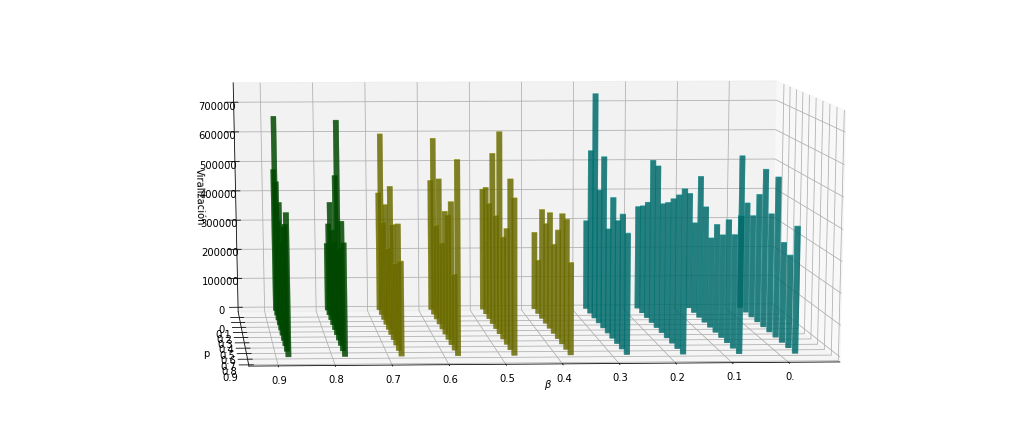

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

filas    = 10
columnas = 10

column_betas = ['0.','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
row_fraccion = ['0.','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']

fig = plt.figure(figsize=(14, 6))  # Inicialmente (8,6)
ax = Axes3D(fig)

lx= len(Resultados_Experimentos[0])            # Work out matrix dimensions
ly= len(Resultados_Experimentos[:,0])
xpos = np.arange(0,lx,1)                       # Set up a mesh of positions
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)

xpos = xpos.flatten()   # Convert positions to 1D array
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.1 * np.ones_like(zpos)  # CAMBIANDO DE 0.5 a menores valores, la barra sale más fina
dy = dx.copy()
dz = Resultados_Experimentos.flatten()

#cs = ['r', 'g', 'b', 'y', 'c', 'w', 'm', 'b'] * ly     # Poner tantos colores como barras
#cs = ['r', 'g', 'b', 'y', 'c', 'w', 'm', 'b', 'g', 'r'] * ly
cs = ['c', 'c', 'c', 'c', 'y', 'y', 'y', 'y', 'g', 'g'] * ly

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs, alpha=0.6)

ax.w_xaxis.set_ticklabels(column_betas)
ax.w_yaxis.set_ticklabels(row_fraccion)
# ------------------------------
ticksx = np.arange(0.5, 10, 1)             # Corresponde a BETAS
plt.xticks(ticksx, column_betas)
ticksy = np.arange(0.8, 10, 1)             # Corresponde a P
plt.yticks(ticksy, row_fraccion)
# ------------------------------
#plt.xticks(np.arange(0.1, 0.8, step=0.1))
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('p')
ax.set_zlabel('Viralización')

# Cambia a casi nivel del suelo: 
#      ax.view_init(10)  
# (Aumentar 20, 30,... para inclinar el gráfico)
#
# Si introducimos un segund parámetro gira al nivel de inclinación 
# que fuerza el primer parámetro (con 90 es perpendicular al punto de visión)
ax.view_init(10,86)

plt.show()

array([2.42072054e+09, 7.56586711e+08, 9.05493119e+08, 2.41065420e+09,
       1.56806928e+09, 1.77026867e+09, 6.99151954e+09, 2.26971719e+09,
       2.77545294e+09, 1.37199056e+09])

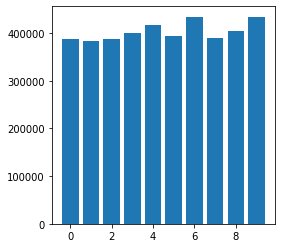

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
medias_por_beta = np.mean(Resultados_Experimentos, axis=1)
var_por_beta    = np.var(Resultados_Experimentos, axis=1)
#plt.plot(medias_por_beta)
#plt.bar(range(10), medias_por_beta, yerr=var_por_beta, align='center')
plt.bar(np.arange(len(medias_por_beta)), medias_por_beta)
var_por_beta


<BarContainer object of 10 artists>

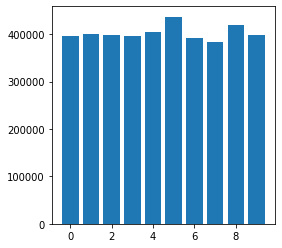

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
medias_por_p = np.mean(Resultados_Experimentos, axis=0)
#plt.plot(medias_por_p)
plt.bar(range(10), medias_por_p)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


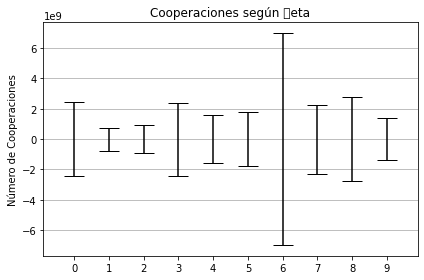

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(medias_por_beta)), medias_por_beta, yerr=var_por_beta, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Número de Cooperaciones')
ax.set_xticks(np.arange(len(medias_por_beta)))
ax.set_xticklabels(np.arange(len(medias_por_beta)))
ax.set_title('Cooperaciones según \beta')
ax.yaxis.grid(True)

# Mostrar
plt.tight_layout()
plt.show()